# Задача колоризации изображений с помощью свёрточных нейронных сетей

### Описание задачи
У нас есть набор фотографий, сделанных с летней смены. Необходимо решить задачу колоризации изображений на основе этого датасета (сбор данных ниже).

Задача колоризации представляет собой преобразование чёрно-белого изображения в цветное с помощью нейронной сети

### Возможные области применения
Данная проблема актуальна, так как за всё время развития человечества накопилось огромное количество чёрно-белых фотографий, колоризация которых может внести большую ясность в происходящие на тот момент события.

К тому же, модель колоризации может позволить хранить картинки в чёрно-белом формате изначально и при необходимости - обрабатывать их.

### Импорты библиотек

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_

from tqdm import tqdm_notebook, tqdm
from time import sleep

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

### 1. Собираем данные и готовим датасет

Возьмём изображения и разорхивируем скачанный архив

In [2]:
!wget http://sereja.me/f/universum_compressed.tar
!tar xf universum_compressed.tar

--2022-01-12 19:53:54--  http://sereja.me/f/universum_compressed.tar
Resolving sereja.me (sereja.me)... 213.159.215.132
Connecting to sereja.me (sereja.me)|213.159.215.132|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72028160 (69M) [application/x-tar]
Saving to: ‘universum_compressed.tar’

universum_compresse 100%[===================>]  68.69M  4.78MB/s    in 19s     

2022-01-12 19:54:14 (3.59 MB/s) - ‘universum_compressed.tar’ saved [72028160/72028160]



Подготавливаем класс датасета

In [3]:
import os
from PIL import Image

class ColorizationDataset(Dataset):
    def __init__(self, path, transform_x, transform_y):
        self.transform_x = transform_x
        self.transform_y = transform_y
      
        filenames = []
        for root, dirs, files in os.walk(path):
            for file in files:
                if file.endswith('.jpg') or file.endswith('.JPG'):
                    filenames.append(os.path.join(root, file))

        self.images = []
        for filename in tqdm(filenames):
            try:
                with Image.open(filename) as image:
                    self.images.append(image.copy()) # Тут self.images - четырёх-мерный объект [палитра, ширина, высота, номер картинки]
            except:
                pass
        print(self.images)

    def __len__(self):
        return len(self.images) # Возвращает количество сэмплов

    def __getitem__(self, idx):
        img = self.images[idx] # Принимает картинку и делает аугментацию
        print(img)
        Y = self.transform_y(img)
        X = self.transform_x(Y)
        return X, Y

Чтобы подавать картинки на вход нейросети, нужно их перевести в тензоры, причём одинакового размера. К тому же, для увеличения датасета произведём необходимые **аугментации** данных

In [4]:
transform_all = transforms.Compose([
    # Вырежем случайный квадратик 128 на 128
    transforms.RandomResizedCrop(128),
    # Горизонтально перевернем
    transforms.RandomHorizontalFlip(),
    # Делаем случайный поворот
    transforms.RandomRotation(degrees=(-45, 45)),
    # Делаем перспективу
    transforms.RandomPerspective(distortion_scale=0.7, p=0.5, interpolation=2, fill=0),
    transforms.ToTensor(),
])

def to_grayscale(x):
    return (x[0] * 0.299 + x[1] * 0.587 + x[2] * 0.114).view(1, 128, 128)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:734: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [5]:
dataset = ColorizationDataset('universum-photos', to_grayscale, transform_all)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

100%|██████████| 1254/1254 [00:01<00:00, 695.13it/s]

[<PIL.Image.Image image mode=RGB size=256x124 at 0x7F42A781E690>, <PIL.Image.Image image mode=RGB size=256x124 at 0x7F42A69923D0>, <PIL.Image.Image image mode=RGB size=256x124 at 0x7F42A781EF50>, <PIL.Image.Image image mode=RGB size=256x125 at 0x7F43AD5A9210>, <PIL.Image.Image image mode=RGB size=256x124 at 0x7F42A699D510>, <PIL.Image.Image image mode=RGB size=256x124 at 0x7F42A69A61D0>, <PIL.Image.Image image mode=RGB size=256x124 at 0x7F42A69A6250>, <PIL.Image.Image image mode=RGB size=256x124 at 0x7F42A6930B90>, <PIL.Image.Image image mode=RGB size=256x124 at 0x7F42A6930A10>, <PIL.Image.Image image mode=RGB size=256x124 at 0x7F42A69A6190>, <PIL.Image.Image image mode=RGB size=256x124 at 0x7F42A6930CD0>, <PIL.Image.Image image mode=RGB size=256x124 at 0x7F42A6930A50>, <PIL.Image.Image image mode=RGB size=256x124 at 0x7F42A6930C50>, <PIL.Image.Image image mode=RGB size=256x124 at 0x7F42A6930C90>, <PIL.Image.Image image mode=RGB size=256x124 at 0x7F42A6930D10>, <PIL.Image.Image image m

# 2. Создаём модель

В качестве нейронной сети будем использовать глубокую свёрточную сеть, которая будет по тензору X восстанавливать тензор Y

На вход нам подаётся изображение в формате **[batch_size, n_channels, x, y]**

Необходимо использовать ряд свёрток, max-pooling, а также функцию активации Swish для реализации данной сети. К тому же, нормировка с помощью batchNorm позволит ускорить процесс обучения 

In [6]:
### Более приятная функция активации

In [7]:
class Swish(torch.autograd.Function):
    @staticmethod
    def forward(ctx, i):
        result = i * torch.sigmoid(i)
        ctx.save_for_backward(i)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_variables[0]
        sigmoid_i = torch.sigmoid(i)
        return grad_output * (sigmoid_i * (1 + i * (1 - sigmoid_i)))
    
class CustomSwish(nn.Module):
    def forward(self, input_tensor):
        return Swish.apply(input_tensor)

Создаём класс раскрашивания

In [8]:
class Colorizer(nn.Module):
    def BlockUp(self, input, output):
        return nn.Sequential(nn.Conv2d(input, output, (3, 3), padding=1), # по дефолту stride = 1, а следовательно размерность не меняется
                                                                          # меняем мы только количество каналов
                             nn.MaxPool2d((2, 2), stride=(2, 2)), # а вот тут мы уменьшаем и высоту, и ширину, в два раза
                             CustomSwish(), # Функция активации Swish
                             nn.BatchNorm2d(output)) # Нормализуем параметры для быстрого обучения сети
        

    def BlockDown(self, input, output):
        return nn.Sequential(nn.Upsample(scale_factor=2),
                             nn.Conv2d(input, output, (3, 3), padding=1),
                             CustomSwish(),
                             nn.BatchNorm2d(output))


    def __init__(self):
        super().__init__()
        
        self.preconcat = nn.Sequential(
            self.BlockUp(1, 32),
            self.BlockUp(32, 64),
            self.BlockUp(64, 128),
            self.BlockUp(128, 256),

            nn.Conv2d(256, 256, (3, 3), padding=1),
            nn.BatchNorm2d(256),
            CustomSwish(),

            nn.Conv2d(256, 256, (3, 3), padding=1),
            nn.BatchNorm2d(256),
            CustomSwish(),
            
            self.BlockDown(256, 192),
            self.BlockDown(192, 128),
            self.BlockDown(128, 96),
            self.BlockDown(96, 64)     
        )
         
        self.postconcat = nn.Sequential(         # Эта сетка нужна для того, чтобы из прошлой сетки вместе с яркостью (начальном изображении)
            nn.Conv2d(65, 32, (3, 3), padding=1), # совмещались и выдавали нормальный окрашенный результат
            nn.BatchNorm2d(32),
            CustomSwish(),
            nn.Conv2d(32, 3, (3, 3), padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        h = self.preconcat(x) # Сначала картинку переводим первой сеткой
        # Затем коннектим исходное чб изображение -- просто дополнительным слоем
        h = torch.cat((h, x), 1)
        h = self.postconcat(h) # Получаем изображение после второй сетки
        return h

# Обучение
Обучаем нейронную сеть. В качестве лосса возьмём средний квадрат ошибок, а оптимизатором - Adam

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
num_epochs = 125
lr = 5e-3

model = Colorizer().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

In [ ]:
history = []
for epoch in tqdm_notebook(range(num_epochs)):
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()

        y_ = model(x)
        loss = criterion(y, y_)
        history.append(loss)

        loss.backward()

        # Не допустить взрыва градиента
        clip_grad_norm_(model.parameters(), 99999) 
        optimizer.step()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/125 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  


#### Как мы видим, модель успешно обучилась и демонстрирует неплохие результаты

In [ ]:
def to_numpy_image(img):
    return img.detach().cpu().view(3, 128, 128).transpose(0, 1).transpose(1, 2).numpy()

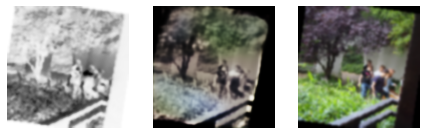

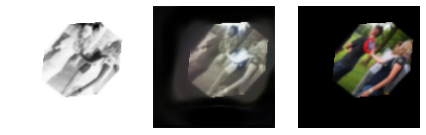

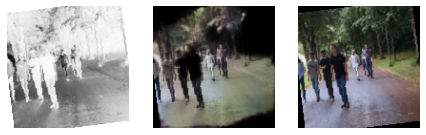

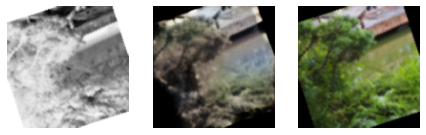

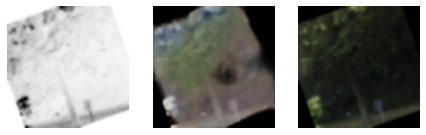

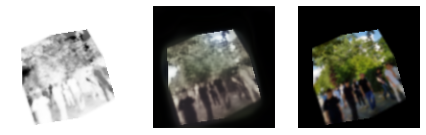

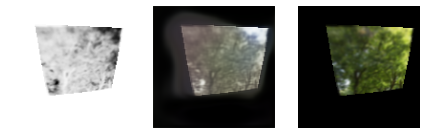

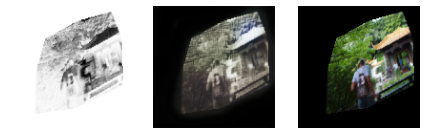

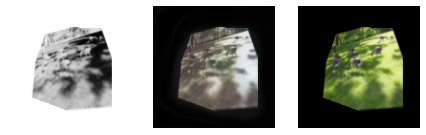

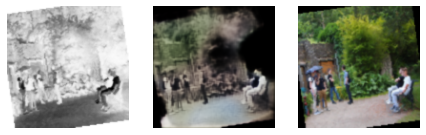

In [ ]:
for t in range(10):
    img_gray, img_true = dataset[t]
    img_pred = model(img_gray.to(device).view(1, 1, 128, 128))
    img_pred = to_numpy_image(img_pred)
    plt.figure(figsize=(10,10))
    
    plt.subplot(141)
    plt.axis('off')
    plt.set_cmap('Greys')
    plt.imshow(img_gray.reshape((128, 128)))

    plt.subplot(142)
    plt.axis('off')
    plt.imshow(img_pred.reshape((128, 128, 3)))

    plt.subplot(143)
    plt.axis('off')
    plt.imshow(to_numpy_image(img_true))
    
    plt.show()

In [ ]:
# Скачаем нашу модель
torch.save(model, "colorization_model.h5")

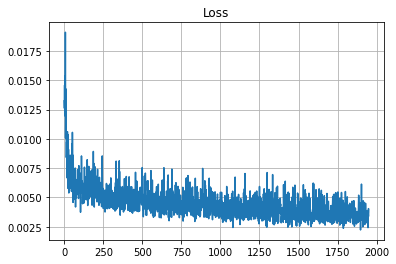

In [ ]:
# Посмотрим на лосс
plt.title("Loss")
plt.grid()
plt.plot(history[50:])